In [1]:
import math
import sys
import numpy as np
import re
import string
import random
from random import randint
import cv2
import os

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plti


env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


2022-12-17 12:52:24.332205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 12:52:24.823849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: $LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
2022-12-17 12:52:24.823891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: $LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
2022-12-17 12:52:24.823896: W tensorflow/compiler/tf2tenso

In [2]:
# CONSTANTS
IM_PATH = "/home/fizzer/labelled_plates"
DST_PATH = "/home/fizzer/labelled_dsts"
NUM_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-5
HSV_LOWER = np.array([115,80,90])
HSV_UPPER = np.array([130,255,205])
DST_LOWER = np.array([0,0,0])
DST_UPPER = np.array([0,0,90])

In [3]:
# PLATES
# CP_PATH = "/home/fizzer/cnn_trainer/letter_model/cps/"
# SAVE_PATH = "/home/fizzer/cnn_trainer/letter_model/save/"

In [4]:
# DSTS
CP_PATH = "/home/fizzer/cnn_trainer/dst_model/cps/"
SAVE_PATH = "/home/fizzer/cnn_trainer/dst_model/save/"

In [5]:
# Set up one hot reference 
one_hot_ref = "12345678"
def one_hot_map(c):
    arr = np.zeros(len(one_hot_ref))
    arr[one_hot_ref.find(c)] = 1
    return arr

In [6]:
# i = cv2.imread(f"{IM_PATH}/PLT_000013_IP61.png")
# hsv = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
# blur = cv2.GaussianBlur(hsv, (5,5), cv2.BORDER_DEFAULT)
# # Mask -> Get contours -> Take 4 Largest contours
# i_mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
# contours, _ = cv2.findContours(i_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
# # Sort contours left to right
# rects = []
# for cnt in cnts_sorted:
#     x,y,w,h = cv2.boundingRect(cnt)
#     rects.append([x,y,w,h])
# rects = np.array(rects)
# rects = sorted(rects, key=lambda x: x[0])
# # Show a slice
# x,y,w,h = rects[0]
# cv2.imshow("img", i_mask[y:y+h,x:x+w])
# cv2.waitKey(1)

In [7]:
KERNEL = np.ones((3,3), np.uint8)
def get_char(img, char, rect):
    x,y,w,h = rect
    im = cv2.resize(img[y:y+h,x:x+w], (75,100))
    im = cv2.erode(cv2.dilate(im, KERNEL, iterations=1), KERNEL, iterations=1)
    return (one_hot_map(char), im)

In [8]:
# THIS IS FOR READING THE PLATE NUMBERS/LETTERS
def crop_plate(plate_path):
    img = cv2.imread(f"{IM_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    # Perform image processing
    return get_char(mask, plate_path[-8], rects[0]), get_char(mask, plate_path[-7], rects[1]), get_char(mask, plate_path[-6], rects[2]), get_char(mask, plate_path[-5], rects[3])

In [9]:
# THIS IS FOR READING THE "CAR NUMBER"
def crop_dst(plate_path):
    img = cv2.imread(f"{DST_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(hsv, DST_LOWER, DST_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-2:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    print(plate_path[-5])
    return get_char(mask, plate_path[-5], rects[1])

In [10]:
imset = []

# Read plates
# dir_contents = np.array(os.listdir(IM_PATH))
# for im_path in dir_contents:
   # Plates
#    p1,p2,p3,p4 = crop_plate(im_path)
#    imset.extend([p1,p2,p3,p4])

# Read dsts
dir_contents = np.array(os.listdir(DST_PATH))
for im_path in dir_contents:
  # DSTs
   p1 = crop_dst(im_path)
   imset.extend([p1])


dataset = np.array(imset)
np.random.shuffle(dataset)

/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


1
2
4
3
2
2
6
2
8
1
6
3
6
3
6
5
7
8
2
1
7
6
4
3
8
6
7
8
6
6
7
1
5
5
1
3
6
1
6
5
2
6
5
7
4
4
2
3
3
5
8
3
2
4
8
1
8
7
3
7
3
1
2
6
7
3
2
4
7
1
4
3
2
2
6
6
7
6
4
2
4
5
1
3
5
4
6
4
7
5
2
5
4
7
3
5
8
1
3
8
7
2
2
3
5
5
3
8
6
8
8
7
3
7
6
6
6
1
2
2
2
3
1
2
8
3
7
3
6
5
7
7
3
7
3
8
5
6
5
7
8
8
8
7
1
7
5
3
4
8
5
5
5
5
3
3
1
6
6
6
5
8
4
4
2
8
7
3
2
3
4
7
3
6
4
2
3
6
2
2
7
6
8
4
3
4
8
8
2
2
3
7
5
4
1
5
7
5
7
5
7
1
7
5
4
4
3
2
4
2
2
6
2
2
4
4
4
3
4
8
4
8
1
3
5
7
7
5
5
4
6
3
4
6
5
6
3
8
6
1
2
7
7
4
6
8
7
2
3
3
4
6
6
6
1
3
6
4
7
7
8
2
6
1
4
2
6
2
6
2
4
3
8
8
1
1
3
4
3
2
5
4
6
6
5
8
1
6
5
1
3
2
1
5
3
4
2
3
5
7
2
5
8
5
2
1
1
7
3
6
2
2
5
5
4
7
7
4
1
4
2
6
7
3
4
7
7
8
4
1
3
7
1
8
8
5
7
2
6
7
5
2
6
6
7
8
2
3
2
4
5
7
5
3
1
3
2
4
7
8
6
8
7
2
1
4
7
6
5
4
2
7
2
7
7
3
8
4
6
2
4
1
4
2
6
2
6
7
3
4
5
8
5
6
6
1
3
7
2
8
4
2
2
5
4
3
4
5
7
1
4
7
6
7
6
2
7
3
1
3
3
5
6
5
5
4
7
5
4
6
5
I
3
7
2
3
6
2
3
7
4
3
3
3
5
6
8
1
8
5
3
4
2
4
2
1
8
2
4
3
5
7
7
3


/tmp/ipykernel_74164/854416707.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(imset)


In [11]:
x_dataset = np.array([img[1][:] for img in imset[:]])
y_dataset = np.array([img[0] for img in imset[:]])
x_dataset = x_dataset/255.0
x_dataset = x_dataset.reshape(len(x_dataset), len(x_dataset[0]), len(x_dataset[0][0]), -1)
print(x_dataset.shape)

(464, 100, 75, 1)


In [12]:
# TODO: The following was copy pasted - validate
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and 
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [13]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(100, 75, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(48, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(256, activation='relu'))
conv_model.add(layers.Dense(8, activation='softmax'))
cp_callback = callbacks.ModelCheckpoint(filepath=CP_PATH, save_weights_only=True, verbose=1)

2022-12-17 12:52:28.432826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:52:28.444641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:52:28.444776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 12:52:28.445169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [14]:
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [15]:
history_conv = conv_model.fit(x_dataset, y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=16,
                              callbacks=[cp_callback])

Epoch 1/20


2022-12-17 12:52:29.648689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-17 12:52:30.557526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-17 12:52:30.558628: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1d0a78d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-17 12:52:30.558641: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2022-12-17 12:52:30.562560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-17 12:52:30.620040: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

24/24 [==============================] - ETA: 0s - loss: 2.0665 - acc: 0.1752
Epoch 1: saving model to /home/fizzer/cnn_trainer/dst_model/cps/
24/24 [==============================] - 3s 14ms/step - loss: 2.0665 - acc: 0.1752 - val_loss: 1.9936 - val_acc: 0.4731
Epoch 2/20
19/24 [======================>.......] - ETA: 0s - loss: 1.9940 - acc: 0.3158
Epoch 2: saving model to /home/fizzer/cnn_trainer/dst_model/cps/
24/24 [==============================] - 0s 9ms/step - loss: 1.9807 - acc: 0.3504 - val_loss: 1.9059 - val_acc: 0.7204
Epoch 3/20
20/24 [========================>.....] - ETA: 0s - loss: 1.8978 - acc: 0.5469
Epoch 3: saving model to /home/fizzer/cnn_trainer/dst_model/cps/
24/24 [==============================] - 0s 7ms/step - loss: 1.8916 - acc: 0.5499 - val_loss: 1.8114 - val_acc: 0.7527
Epoch 4/20
21/24 [=========================>....] - ETA: 0s - loss: 1.8169 - acc: 0.6310
Epoch 4: saving model to /home/fizzer/cnn_trainer/dst_model/cps/
24/24 [==============================

In [16]:
conv_model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/dst_model/save/assets


INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/dst_model/save/assets


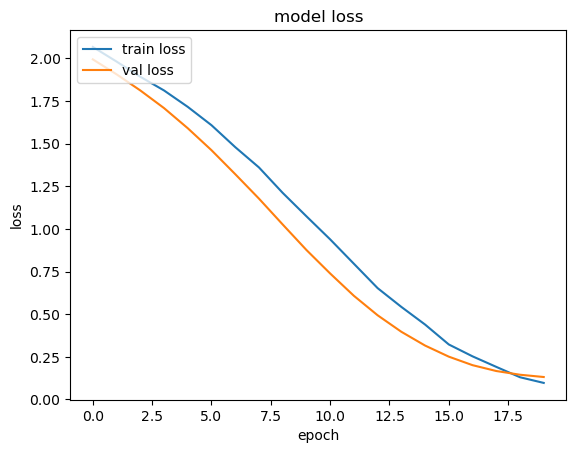

In [17]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

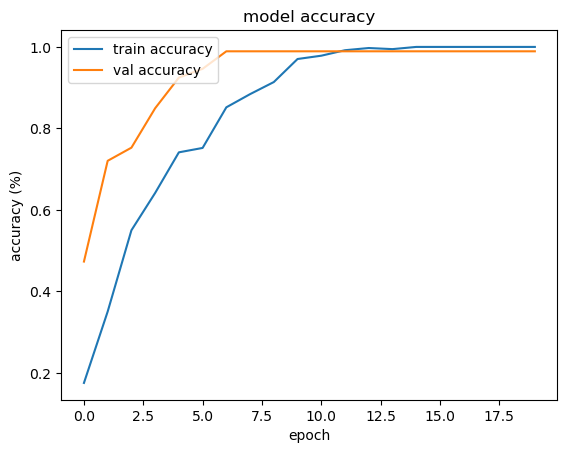

In [18]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix

15/15 [==============================] - 0s 1ms/step


<AxesSubplot:>

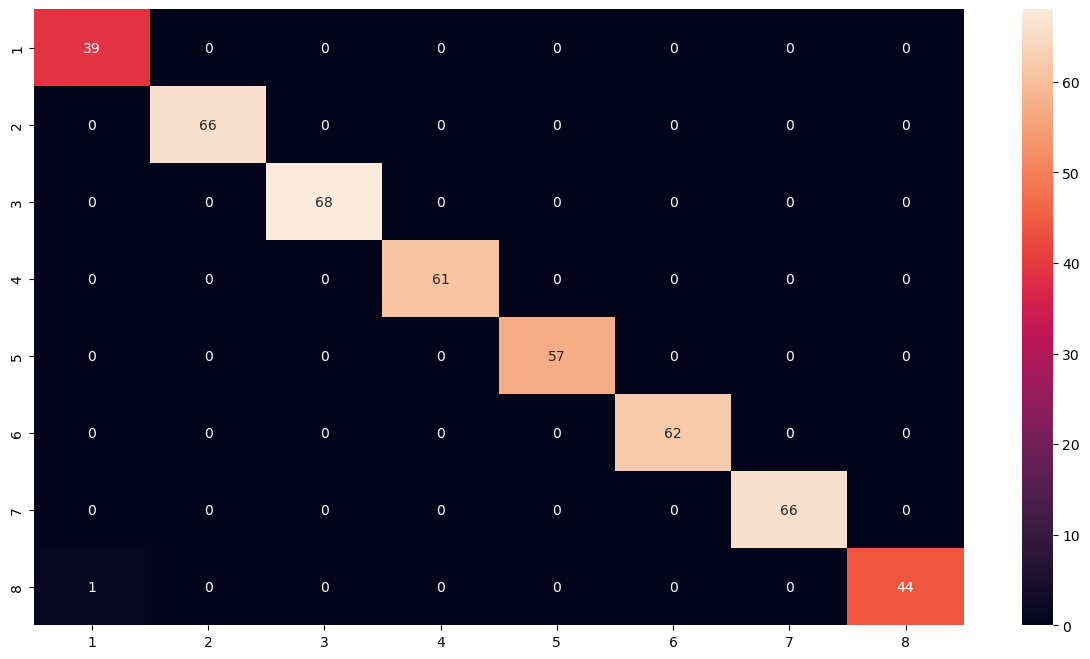

In [20]:
pred_matrix = conv_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [i for i in one_hot_ref],
                  columns = [i for i in one_hot_ref])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

In [21]:
pred_matrix = conv_model.predict(x_dataset)
pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

15/15 [==============================] - 0s 1ms/step


In [22]:
print(conv_model.predict(x_dataset)[0])

15/15 [==============================] - 0s 1ms/step
[9.5779836e-01 7.5010373e-03 1.4614155e-02 4.6419641e-03 4.0911818e-03
 6.2794331e-03 4.6106461e-03 4.6323147e-04]


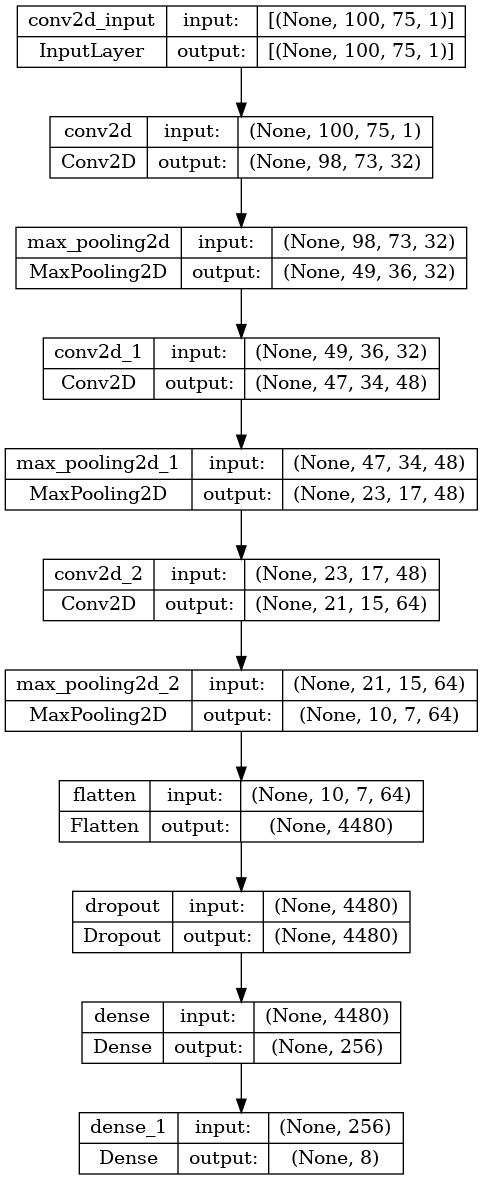

In [23]:
plot_model(conv_model, to_file='dst_model.png', show_shapes=True)